In [2]:
# Use Pandas to load our data.
import scipy as sp
import numpy as np
import pandas as pd
import json
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import ensemble
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.5)
%matplotlib inline

In [3]:
# read Yelp user review file into a python array
with open('../../../../../Downloads/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json', 'rb') as f:
    data = f.readlines()
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"
df_user_reviews = pd.read_json(data_json_str)

In [4]:
# read Yelp business review file into a python array
with open('../../../../../Downloads/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json', 'rb') as f:
    data = f.readlines()

data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"
df_businesses = pd.read_json(data_json_str)

In [5]:
#get businesses that are restaurants
def getRes(cats):
    for cat in cats:
        if cat == "Restaurants":
            return 1

In [6]:
#get only restaurants data and reset the index
df_businesses["Restaurant"] = df_businesses.categories.apply(getRes)
df_business_res = (df_businesses[df_businesses.Restaurant == 1.0]).copy()
df_business_res = df_business_res.drop("Restaurant", axis=1)
df_working = pd.merge(df_user_reviews, df_business_res, on="business_id", suffixes=('_review', '_business'))
df_working['date'] = pd.to_datetime(df_working['date'])
df_working.set_index('date', inplace=True)
df_working['year'] = df_working.index.year
df_working['month'] = df_working.index.month

In [7]:
#clean up data
df_working = df_working.drop("latitude", axis=1)
df_working = df_working.drop("longitude", axis=1)
df_working = df_working.drop("type_business", axis=1)
df_working = df_working.drop("type_review", axis=1)
df_working = df_working.drop("votes", axis=1)
df_working = df_working.drop("full_address", axis=1)
df_working = df_working.drop("hours", axis=1)
df_working = df_working.drop("neighborhoods", axis=1)

In [8]:
#import price data from json and convert categories to string to be able to search
df_working['price'] = df_working.attributes.map(lambda x: json.dumps(x))
df_working['price'] = df_working.price.map(lambda x: json.loads(x).get('Price Range', ''))
df_working['price'] = df_working.price.convert_objects(convert_numeric=True)
df_working['categories_2'] = df_working['categories'].astype('str') 

/Users/amrutag/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [9]:
#create dummy variables for price
dummies = pd.get_dummies(df_working.price, prefix="price")
df_working = pd.concat([df_working, dummies], axis=1)

In [10]:
df_working.shape

(1363242, 21)

In [11]:
df_working.columns

Index([   u'business_id',      u'review_id',   u'stars_review',
                 u'text',        u'user_id',     u'attributes',
           u'categories',           u'city',           u'name',
                 u'open',   u'review_count', u'stars_business',
                u'state',           u'year',          u'month',
                u'price',   u'categories_2',      u'price_1.0',
            u'price_2.0',      u'price_3.0',      u'price_4.0'],
      dtype='object')

In [12]:
df_working.describe()

/Users/amrutag/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,stars_review,review_count,stars_business,year,month,price,price_1.0,price_2.0,price_3.0,price_4.0
count,1.363242e+06,1.363242e+06,1.363242e+06,1.363242e+06,1.363242e+06,1.356627e+06,1.363242e+06,1.363242e+06,1.363242e+06,1.363242e+06
mean,3.736939e+00,4.108197e+02,3.729141e+00,2.012995e+03,6.598057e+00,1.874950e+00,2.687366e-01,6.104793e-01,8.756993e-02,2.836180e-02
std,1.302318e+00,7.273045e+02,5.570203e-01,1.603686e+01,3.376071e+00,6.755791e-01,4.433028e-01,4.876418e-01,2.826685e-01,1.660043e-01
min,1.000000e+00,3.000000e+00,1.000000e+00,2.004000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,7.000000e+01,3.500000e+00,2.012000e+03,4.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,1.760000e+02,4.000000e+00,2.014000e+03,7.000000e+00,NaN,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,4.110000e+02,4.000000e+00,2.015000e+03,9.000000e+00,NaN,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,5.000000e+00,5.642000e+03,5.000000e+00,2.015000e+03,1.200000e+01,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [22]:
df_working[['stars_review', 'review_count', 'open', 'stars_business', 'price']].corr()

,stars_review,review_count,open,stars_business,price
stars_review,1.000000,0.073063,0.048143,0.398845,0.022634
review_count,0.073063,1.000000,0.127398,0.167174,0.213545
open,0.048143,0.127398,1.000000,0.110348,0.002237
stars_business,0.398845,0.167174,0.110348,1.000000,0.047419
price,0.022634,0.213545,0.002237,0.047419,1.000000


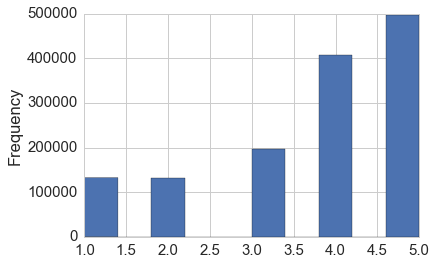

In [13]:
df_working.stars_review.plot(kind='hist')

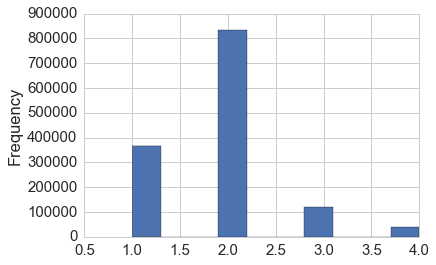

In [14]:
df_working.price.plot(kind='hist')

(427, 21)
Axes(0.125,0.125;0.775x0.775)


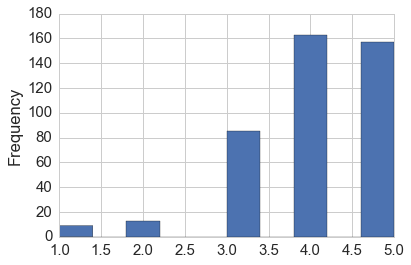

In [17]:
print df_working['2005'].shape
print df_working['2005'].stars_review.plot(kind='hist')

(395697, 21)
Axes(0.125,0.125;0.775x0.775)


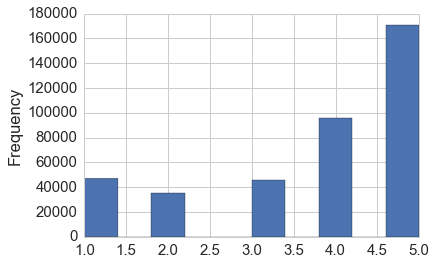

In [16]:
print df_working['2015'].shape
print df_working['2015'].stars_review.plot(kind='hist')

In [18]:
print df_working['2005'].stars_review.mean()
print df_working['2010'].stars_review.mean()
print df_working['2011'].stars_review.mean()
print df_working['2012'].stars_review.mean()
print df_working['2013'].stars_review.mean()
print df_working['2014'].stars_review.mean()
print df_working['2015'].stars_review.mean()

4.04449648712
3.70663991203
3.70885002492
3.69971018993
3.71947771327
3.7456423825
3.77987702712


In [19]:
df_expensive = df_working[df_working.price == 4.0]
df_cheap = df_working[df_working.price == 1.0]
print df_expensive.shape
print df_cheap.shape

(38664, 21)
(366353, 21)


3.7596798716


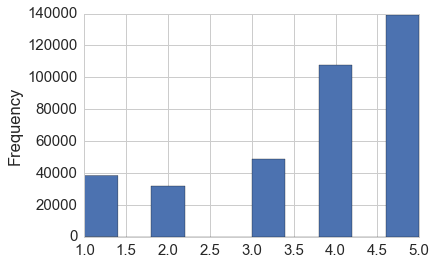

In [20]:
df_cheap.stars_review.plot(kind='hist')
print df_cheap.stars_review.mean()

4.01986343886


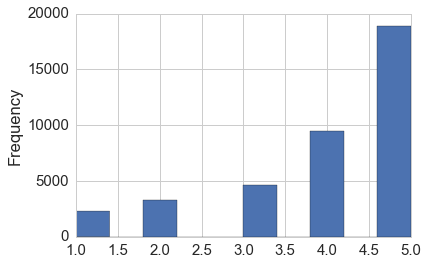

In [21]:
df_expensive.stars_review.plot(kind='hist')
print df_expensive.stars_review.mean()

In [30]:
df_working['open'].value_counts()

True     1199926
False     163316
Name: open, dtype: int64

In [32]:
df_working.groupby("business_id").review_count.count().sort_values(ascending=False)

business_id
4bEjOyTaDG24SY5TxsaUNQ    5042
zt1TpTuJ6y9n551sw9TaEg    3958
2e2e7WgqU1BnpxmQL5jbfw    3896
sIyHTizqAiGu12XMLX3N3g    3788
aGbjLWzcrnEx2ZmMCFm3EA    3405
Xhg93cMdemu5pAMkDoEdtQ    3086
YNQgak-ZLtYJQxlDwN-qIg    2876
QbmcCE_cLq4WO8ZMKImaLw    2704
tFU2Js_nbIZOrnKfYJYBBg    2589
CZjcFdvJhksq9dy58NVEzw    2576
lliksv-tglfUz1T3B3vgvA    2548
xfwRO04KbAPw_zRotCfWQQ    2468
eq6lQI039SBLC6sHm3idGA    2394
PXviRcHR1mqdH4vRc2LEAQ    2202
DO3Gk17RyJVW7zYMCtYPnw    2197
mDdqifuTrfXAOfxiLMGu5Q    1989
xyTJYlbE_MLouK6rCou6zg    1924
BqrTtox0JbG-P_DKBB5bBw    1870
jOuERtVf7QePnK9ZcdH5XA    1711
FV16IeXJp2W6pnghTz2FAw    1704
iUPJmJvHy9fVfRxsuwwdLQ    1701
SsTxjxo8qvqBMvan1rzNzg    1612
HbUQ_3dlm3uCacmhTEMnuA    1544
DjOxXobyGDwWt89q4z1twg    1503
1yx2zLskVTe5WQdYjL2Apw    1465
VVeogjZya58oiTxK7qUjAQ    1461
JokKtdXU7zXHcr20Lrk29A    1443
vxxMqBaAHuWdx4impsLSSA    1439
tqu42L0qXzkvYKSruOz0IA    1408
NsnZ5GhagXBKrCOelxVQxw    1402
                          ... 
qnE_bJoQlbW94yLYKAeH5A     

In [33]:
df_res1 = df_working[df_working.business_id == "4bEjOyTaDG24SY5TxsaUNQ"]

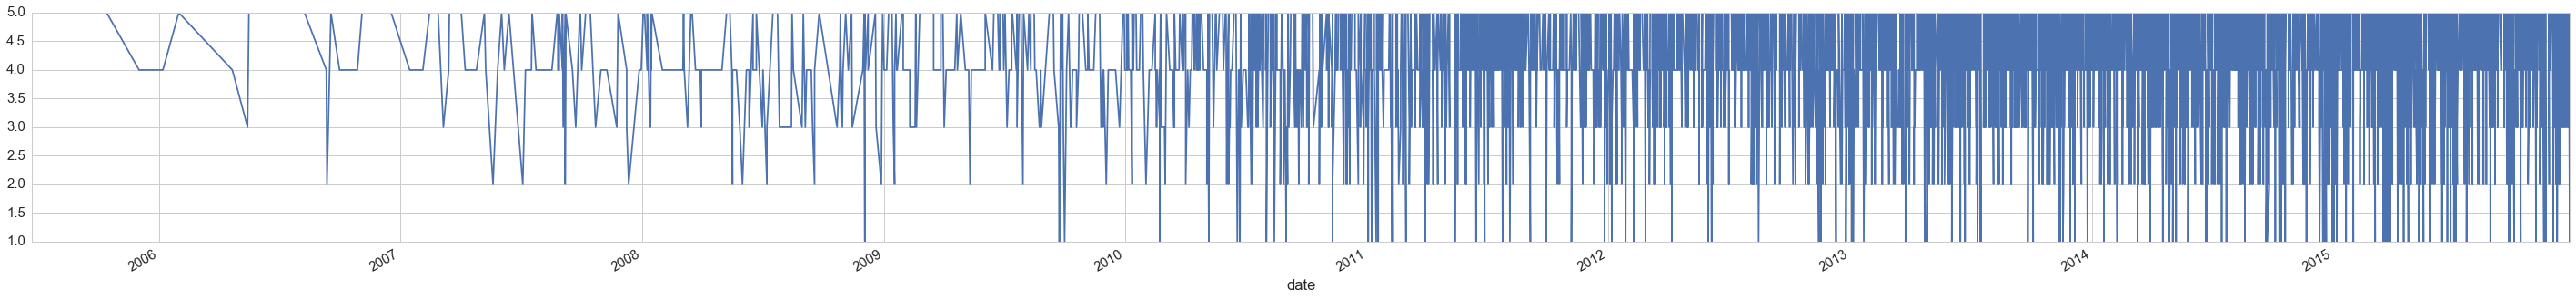

In [34]:
df_res1.stars_review.plot(figsize=(50, 5))

In [37]:
df_res1.stars_review.resample('AS').mean().autocorr(lag=1)

0.74345342509923995

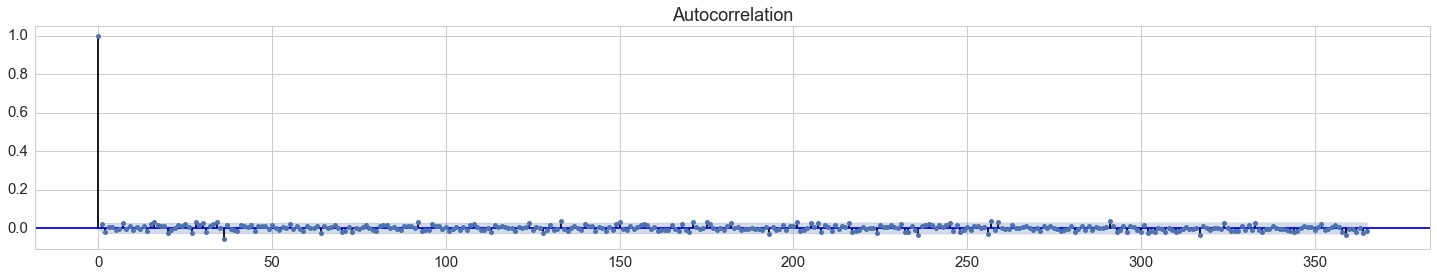

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(df_res1.stars_review, lags=365)
fig.set_figwidth(25)

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.ldamodel import LdaModel
from gensim.models.hdpmodel import HdpModel
from gensim.matutils import Sparse2Corpus
import gensim

In [ ]:
#didn't get to use this category model
category_vec = TfidfVectorizer(max_df=.8, min_df=.01, ngram_range=(1, 2), stop_words='english', lowercase=True)
V = category_vec.fit_transform(df_working.categories_2)

id2word_cat = dict(enumerate(category_vec.get_feature_names()))
corpus_cat = Sparse2Corpus(V, documents_columns = False)

In [ ]:
lda_model_cat = LdaModel(corpus=corpus_cat, id2word=id2word_cat, num_topics=30)

In [ ]:
num_topics = 30
num_words_per_topic = 5
for ti, topic in enumerate(lda_model_cat.show_topics(num_topics = num_topics, num_words = num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

In [38]:
y = df_working.stars_review
X = df_working

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.20)

In [45]:
#creating corpus of training set to test for perplexity
vectorizer_sample = TfidfVectorizer(max_df=.8, min_df=.01, ngram_range=(1,2), stop_words='english', lowercase=True)
v_sample = vectorizer_sample.fit_transform(X_train.text)

id2word_sample = dict(enumerate(vectorizer_sample.get_feature_names()))

corpus = Sparse2Corpus(v_sample, documents_columns=False)

In [51]:
lda_model_15 = LdaModel(corpus=corpus, id2word=id2word_sample, num_topics=15)

In [56]:
lda_model_5 = LdaModel(corpus=corpus, id2word=id2word_sample, num_topics=5)

In [52]:
lda_model_30 = LdaModel(corpus=corpus, id2word=id2word_sample, num_topics=30)

In [53]:
lda_model_40 = LdaModel(corpus=corpus, id2word=id2word_sample, num_topics=40)

In [46]:
lda_model_45 = LdaModel(corpus=corpus, id2word=id2word_sample, num_topics=45)

In [54]:
lda_model_60 = LdaModel(corpus=corpus, id2word=id2word_sample, num_topics=60)

In [55]:
lda_model_100 = LdaModel(corpus=corpus, id2word=id2word_sample, num_topics=100)

In [48]:
num_topics = 45
num_words_per_topic = 15
for ti, topic in enumerate(lda_model_45.show_topics(num_topics = num_topics, num_words = num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, u'0.021*looked + 0.018*decided + 0.013*looked like + 0.013*like + 0.013*decided try + 0.012*try + 0.009*good + 0.009*place + 0.009*just + 0.008*food + 0.008*stick + 0.008*got + 0.008*saw + 0.008*ordered + 0.007*didn')
()
Topic: 1
(1, u'0.024*horrible + 0.024*food + 0.023*terrible + 0.022*worst + 0.019*service + 0.018*awful + 0.017*rude + 0.017*quality food + 0.016*quality + 0.016*bad + 0.014*poor + 0.014*money + 0.013*mediocre + 0.011*place + 0.011*spend')
()
Topic: 2
(2, u'0.020*line + 0.019*long + 0.017*wait + 0.015*waiting + 0.014*time + 0.012*20 + 0.011*food + 0.011*minutes + 0.011*long time + 0.011*20 minutes + 0.010*order + 0.009*40 + 0.009*ready + 0.008*people + 0.008*understand')
()
Topic: 3
(3, u'0.047*brunch + 0.019*fruit + 0.018*sunday + 0.014*desert + 0.014*orange + 0.013*breakfast + 0.009*good + 0.008*great + 0.007*place + 0.007*food + 0.007*menu + 0.006*fresh + 0.006*coffee + 0.006*toast + 0.006*like')
()
Topic: 4
(4, u'0.075*sushi + 0.068*great + 0.038*great

In [49]:
v_per = vectorizer_sample.transform(X_test.text)

corpus_per = Sparse2Corpus(v_per, documents_columns = False)

In [57]:
print lda_model_5.log_perplexity(corpus_per)
print lda_model_15.log_perplexity(corpus_per)
print lda_model_30.log_perplexity(corpus_per)
print lda_model_40.log_perplexity(corpus_per)
print lda_model_60.log_perplexity(corpus_per)
print lda_model_100.log_perplexity(corpus_per)

-6.93544187571
-7.30566244019
-7.73927728986
-8.00770716499
-8.48251656657
-9.33814809199


In [50]:
print lda_model_45.log_perplexity(corpus_per)

-8.14055872209


In [58]:
perplexity_df= pd.DataFrame({'topic' : pd.Series([5., 15., 30., 40., 45., 60., 100.]),
   ....:      'perplexity' : pd.Series([6.94, 7.30, 7.73, 8.01, 8.14, 8.48, 9.34])})

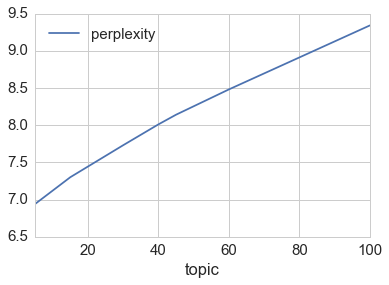

In [59]:
perplexity_df.plot(x="topic")

In [60]:
#creating corpus for entire datast
vectorizer_sample_45 = TfidfVectorizer(max_df=.8, min_df=.01, ngram_range=(1,2), stop_words='english', lowercase=True)
v_sample_45 = vectorizer_sample_45.fit_transform(df_working.text)

id2word_sample_45 = dict(enumerate(vectorizer_sample_45.get_feature_names()))

corpus_45 = Sparse2Corpus(v_sample_45, documents_columns=False)

In [61]:
lda_model_45_2 = LdaModel(corpus=corpus_45, id2word=id2word_sample_45, num_topics=45)

In [62]:
scoresList = []

for document in corpus_45:
    scores = lda_model_45_2[document]
    testList = {}
    for topic in scores:
        testList[topic[0]] = topic[1]
    scoresList.append(testList)

In [103]:
num_topics = 45
num_words_per_topic = 15
for ti, topic in enumerate(lda_model_45_2.show_topics(num_topics = num_topics, num_words = num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, u'0.028*potato + 0.026*sweet + 0.022*yum + 0.020*sweet potato + 0.016*chicken + 0.012*salad + 0.012*delicious + 0.012*generous + 0.011*fries + 0.011*shared + 0.011*roasted + 0.010*sauce + 0.009*lemon + 0.009*blue + 0.009*cheese')
()
Topic: 1
(1, u'0.102*tacos + 0.032*pulled + 0.031*fish + 0.030*pork + 0.019*corn + 0.015*chips + 0.013*good + 0.012*salsa + 0.012*street + 0.010*great + 0.009*shrimp + 0.008*bbq + 0.008*place + 0.008*try + 0.008*delicious')
()
Topic: 2
(2, u'0.031*recommend place + 0.029*wine + 0.019*dining + 0.014*dining experience + 0.013*experience + 0.013*recommend + 0.012*glass + 0.010*place + 0.010*tasting + 0.010*bottle + 0.010*great + 0.009*restaurant + 0.008*food + 0.008*menu + 0.008*list')
()
Topic: 3
(3, u'0.059*thank + 0.048*employees + 0.042*try place + 0.041*clean + 0.030*lol + 0.023*owner + 0.022*today + 0.021*job + 0.020*store + 0.020*helpful + 0.019*kinda + 0.019*yelp + 0.018*late + 0.016*craving + 0.016*tonight')
()
Topic: 4
(4, u'0.053*excell

In [63]:
df_topics = pd.DataFrame(scoresList)
df_topics = df_topics.fillna(value=0, axis=0)

In [79]:
X2 = df_working

In [82]:
X2.reset_index(inplace=True)

In [83]:
df_new = pd.concat([X2, df_topics], axis=1)

In [64]:
def change(n):
    if n > 3:
        return 1
    else:
        return 0

df_working["Value"] = df_working.stars_review.apply(change)

In [70]:
#baseline
float(df_working.Value.sum())/float(df_working.count()[0])

0.6631962630259338

In [71]:
X1 = df_topics
y = df_working.Value

In [72]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X1, y, test_size=0.4, random_state=42)
clf = ensemble.RandomForestClassifier(n_estimators=200, max_depth=30)
clf.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test, y_test)
# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

Accuracy: 0.776
ROC AUC: 0.806


In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X2, y, test_size=0.4, random_state=42)
clf = ensemble.RandomForestClassifier(n_estimators=200, max_depth=30)
clf.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test, y_test)
# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

In [ ]:
y2 = df_working["stars_review"]

In [137]:
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(X1, y2, test_size=0.4, random_state=42)
clf2 = ensemble.RandomForestClassifier(n_estimators=200, max_depth=30)
clf2.fit(X_train, y_train)

# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test2, y_test2)
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

Accuracy: 0.029


In [ ]:
df_new = df_working[df_working.Va]

In [96]:
df_bad_review = df_new[df_new.Value == 0]
df_good_review = df_new[df_new.Value == 1]

In [97]:
df_bad_review = df_bad_review[range(45)]
df_good_review = df_good_review[range(45)]

In [98]:
array_topic_bad = []
for num in range(45):
    array_topic_bad.append(df_bad_review[num].mean())

In [102]:
df_topic_bad = pd.DataFrame(array_topic_bad, columns=["Score"])
df_topic_bad[df_topic_bad.Score > 0.03]

,Score
11,0.076968
12,0.033886
14,0.033196
26,0.052744
31,0.103038


In [100]:
array_topic_good = []
for num in range(45):
    array_topic_good.append(df_good_review[num].mean())

In [101]:
df_topic_good = pd.DataFrame(array_topic_good, columns=["Score"])
df_topic_good[df_topic_good.Score > 0.03]

,Score
8,0.030686
43,0.032329
